# My First Kaggle Competition: Titanic

For more practical experience with gradient descent, I decided to participate in the [Titanic Competition](https://www.kaggle.com/c/titanic). Here is how I did it and what I learned.

I took the following approach:
* Setting up my local machine for the Kaggle competition
* Trying to write as little code as possible, I implemented [notebook](https://github.com/chrwittm/FastAI2022/blob/main/lesson03/titanic/titanic1/titanic1.ipynb) which leveraged a fast.ai tabular learner
* Creating another [notebook](https://github.com/chrwittm/FastAI2022/blob/main/lesson03/titanic/titanic3/titanic3.ipynb) re-implementing Jeremy's Excel-based model

## Installing Kaggle

Getting ready for the Kaggle competition requires registering for the competition (a few clicks on the kaggle website), and installing kaggle on your local machine. The following is based on the [Live-Coding Session 7](https://youtu.be/cagqUrHMDJ0) and the related [official topic in the forums](https://forums.fast.ai/t/live-coding-7/96811).

The first step is to install kaggle:

```bash
pip install --user kaggle
```

As a result, the following warning is displayed: `The script kaggle is installed in '/home/<your user>/.local/bin' which is not on PATH.` This means that the you need to add the path to the `PATH`-variable. This is done by adding the following line to the `.bashrc`-file and restarting the terminal:

```bash
PATH=~/.local/bin:$PATH
```

> Note: To display the current `PATH`-variable use: `echo $PATH`

As a result, typing the `kaggle`-command on the command line works, but the next error shows up (as expected):
`OSError: Could not find kaggle.json. Make sure it's located in /home/chrwittm/.kaggle. Or use the environment method.`

This means that you cannot authorize against the kaggle platform. To solve this, download your personal `kaggle.json`
On the kaggle website, navigate to: "Account" and click on "Create New API Token". As a result, the `kaggle.json` is downloaded.

Copy the `kaggle.json`-file into the `.kaggle`-directory in your home directory.

Typing the `kaggle`-command on the command line gives you the final clue as to what is missing:
`Your Kaggle API key is readable by other users on this system! To fix this, you can run 'chmod 600 /home/chrwittm/.kaggle/kaggle.json'`

Therefore, type: 

```bash
chmod 600 /home/<your user>/.kaggle/kaggle.json
```

Typing the `kaggle`-command on the command line again confirms: We are in business :)

## Downloading the dataset

To download the dataset, run the following command (which you can also find on the kaggle website): 

```bash
kaggle competitions download -c titanic
```

As a result, the file `titanic.zip` is downloaded.

To unzip type:

```bash
unzip titanic.zip
```

Doing this for the first time, this resulted in an error: `/bin/bash: unzip: command not found`

To install zip and unzip, type:

```bash
sudo apt-get install zip
sudo apt-get install unzip
```

As a result, unzipping works, and we have a dataset to work with :).

In [1]:
import pandas as pd

train = pd.read_csv("train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Implementing a Fast.ai Tabular Learner

The goal was not to create a perfect submission, but to simply train a model as fast as possible to
* get a baseline
* to get to know how a kaggle competition works (remember, this is my first one)

Therefore, I created a dataloaders as shown in [lesson 1](https://youtu.be/8SF_h3xF3cE?t=3513) or [in the docs](https://docs.fast.ai/examples/app_examples.html#tabular) by sorting the variables into categorical or continuos one, excluding irrelevant ones).

> Note 1: In this blog post, I am presenting the steps in a fast-forward way, here is the original [notebook](https://github.com/chrwittm/FastAI2022/blob/main/lesson03/titanic/titanic1/titanic1.ipynb).

> Note 2: When writing this up, I was not able to 100% re-produce the same results, but basically this is how the story went.

In [2]:
from fastai.tabular.all import *

path = "."

dls = TabularDataLoaders.from_csv('train.csv', path=path, y_names="Survived",
    cat_names = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked'],
    cont_names = ['Age', 'Fare'],
    procs = [Categorify, FillMissing, Normalize])

Now we can train a model:

In [3]:
learn = tabular_learner(dls, metrics=accuracy)
learn.fit_one_cycle(10) #change this variable for more/less training

epoch,train_loss,valid_loss,accuracy,time
0,0.548652,0.315984,0.640449,00:00
1,0.454461,0.325496,0.640449,00:00
2,0.373511,0.289948,0.640449,00:00
3,0.319270,0.251090,0.640449,00:00
4,0.280473,0.196879,0.640449,00:00
5,0.249269,0.173640,0.640449,00:00
6,0.225535,0.152192,0.640449,00:00
7,0.207350,0.141283,0.640449,00:00
8,0.192223,0.137462,0.640449,00:00
9,0.180697,0.137344,0.640449,00:00


With this learner, we can make the predictions on the test-dataset.

In [4]:
test = pd.read_csv("test.csv")

# replacing null values with 0
test['Fare'] = test['Fare'].fillna(0)

# create Predictions as suggested here:
# https://forums.fast.ai/t/tabular-learner-prediction-using-data-frame/90534/2
test_dl = learn.dls.test_dl(test)
preds, _ = learn.get_preds(dl=test_dl)

test['Survived_pred'] = preds.squeeze()
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived_pred
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0.064765
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0.454887
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,-0.025921
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,-0.015690
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0.508172


Interpreting the values in column `Survived_pred` is important, because we need to turn these values into `0` and `1` for the submission. The submission file should only have the columns `PassengerId` and `Survived`. For the first submission, I did not worry about it too much and simply picked a value `0.5`. (Let's come back to that a little later)

In [5]:
threshold = 0.5 #change this variable for more/less training
test['Survived'] = [ 1 if element > threshold else 0 for element in preds.squeeze()]

submission1 = test[['PassengerId', 'Survived']]
submission1.to_csv('submission1.csv', index=False)

I uploaded the results, and they were better then random ;) - **Score 0.73923**

![First Submission](first_submission.png)

The score is not great, but the whole point was to get a baseline as quickly as possible, and to "play the whole kaggle game". Actually, the fact that I produced this result in about 1-2 hours felt pretty good :).

> Note: Running this notebook, I got a score of 0.75119, I am not sure, what caused the difference... but better is always good ;)

So how can we improve the score? More training, interpreting the results differently? As it turns out: Both.

Let's look at the distribution of `Survived_pred`:

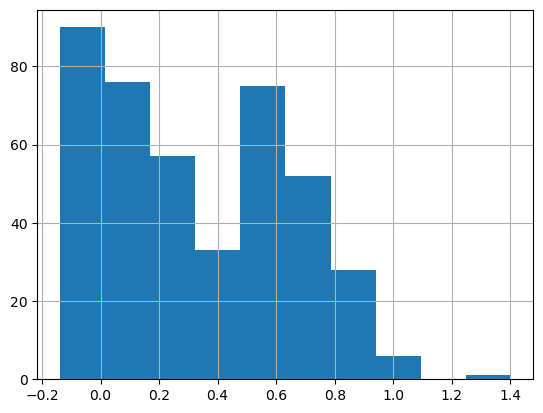

In [6]:
test.Survived_pred.hist();

As it turned out, setting my threshold to `0.6` created a better result: **Score: 0.74162**. (this I could not reproduce with this notebook while writing up the blog post)

Also more training, produced better results, running for 50 cycles, resulted in a lower loss and a better result. Training with 50 cycles and threshold `0.7`, this was the result: **Score: 0.76794** (with this notebook 0.77033)

So there is some randomness when training, and it is important to properly interpret the results. Getting about 77% right with this simple approach is not to bad.

## Re-Implemenmting the Excel Model

After the quick win with Fast.AI, I decided to re-implement what Jeremy did in the Excel in [video lecture 3](https://www.youtube.com/watch?v=hBBOjCiFcuo&list=PLfYUBJiXbdtSvpQjSnJJ_PmDQB_VyT5iU&index=3&t=3862s) to predict the survivors. Let's see how it performs against the Fast.AI tabular learner.

Since that involved quite a bit of code, let me simply link to [notebook](https://github.com/chrwittm/FastAI2022/blob/main/lesson03/titanic/titanic3/titanic3.ipynb) and discuss the learnings / results.

As it turned out:
* I had to do a bit of data cleansing.
* The feature engineering took some time which taught me some general python lessons.
* Implementing the optimizer was a nice exercise, revisiting [gradient descent](https://chrwittm.github.io/posts/2022-10-13-visualizing-gradient-descent-in-3d/) and [matrix multiplication](https://chrwittm.github.io/posts/2022-10-28-matrix-multiplication/), and doing some hands-on work with tensors.

The first model with just one layer scored **0.75837**, even better than the my Fast.AI baseline, but not quite as good as the optimized version.

The next iteration with 2 and 3 layers scored better:
* **Score: 0.77033** (2-layers)
* **Score: 0.77272** (3-layers)

This was quite surprising: The self-written algorithm is better than the Fast.AI one, any ideas why that would be?

Nonetheless, it seems to hit a ceiling at 77%, and it would make sense to dive deeper into tabular data, but that is for another time. My goal was not to optimize the competition result, but to participate in my first kaggle competition, and to re-visit the topic of gradient descent and matrix multiplication. I will most likely return to this dataset/challenge in the future.
